### check
   * exchange balance of bitocin v.s. stables
   * large transfer in of stables v.s. bitcoins -> large trading volume? -> cause price move?

In [7]:
from cdcqr.data.glassnode import glassnode_data as gnd
from cdcqr.ct.utils import plot2
import pandas as pd
import cdcqr.analytics.utils as autil 
from importlib import reload
import seaborn as sns
import matplotlib.pyplot as plt
from cdcqr.analytics.utils import calculate_corr_pvalues
from cdcqr.common.utils import LOCAL_DATA_DIR
import os
import numpy as np
from cdcqr.backtest.vbt.runsignal import runsignal
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import time
from IPython.display import Audio
sound_file = '/core/tmp/ding.wav'
%matplotlib inline

from cdcqr.common.utils import parallel_jobs

In [8]:
runsignal?

Signature:
runsignal(
    price,
    signal,
    tp=6,
    sl=2,
    ts=5,
    n1=1,
    n2=100,
    rsil=30,
    rsih=50,
    rsilag=14,
    maf=5,
    mas=15,
    short=False,
    size=inf,
    fees=0.0007000000000000001,
    freq='1Min',
    init_cash=10000,
    request=None,
)
Docstring: <no docstring>
File:      c:\core\github\cdcqr\cdcqr\backtest\vbt\runsignal.py
Type:      function


In [9]:
gn = gnd.GlassnodeData()

In [10]:
gn.get_feature_best_resolutions('balance_exchanges')

'10m'

In [11]:
[x for x in gn.get_feature_assets('balance_exchanges') if 'USD' in x]

['GUSD', 'USDT', 'USDP', 'USDC', 'BUSD', 'USDK', 'sUSD', 'HUSD']

In [12]:
reload(gnd)
gn = gnd.GlassnodeData()

In [13]:
fs = ['price_usd_close', 'balance_exchanges']
assets = ['BTC','USDT', 'USDC', 'BUSD']
df = gn.load_features(fs, assets, resolution='10m')

loading market/price_usd_close asset=BTC, resolution=10m
loading market/price_usd_close asset=USDT, resolution=10m
loading market/price_usd_close asset=USDC, resolution=10m
loading market/price_usd_close asset=BUSD, resolution=10m
loading distribution/balance_exchanges asset=BTC, resolution=10m
loading distribution/balance_exchanges asset=USDT, resolution=10m
loading distribution/balance_exchanges asset=USDC, resolution=10m
loading distribution/balance_exchanges asset=BUSD, resolution=10m


<AxesSubplot:xlabel='t'>

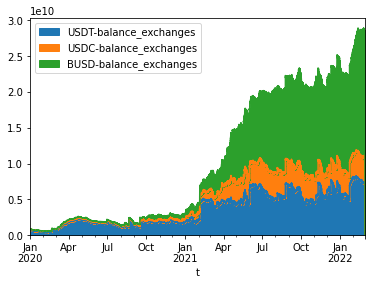

In [14]:
df[df.index>='20200101'][['USDT-balance_exchanges','USDC-balance_exchanges','BUSD-balance_exchanges']].plot.area()

In [15]:
df1 = df[df.index>='20200101'].ffill().drop(['USDT-price_usd_close','USDC-price_usd_close','BUSD-price_usd_close'],axis=1)
df1['stable-balance_exchanges'] = df['USDT-balance_exchanges']+df['USDC-balance_exchanges']+df['BUSD-balance_exchanges']
df1 = df1[['BTC-price_usd_close', 'stable-balance_exchanges','BTC-balance_exchanges']]
df1.head()

,BTC-price_usd_close,stable-balance_exchanges,BTC-balance_exchanges
t,,,
2020-01-01 00:00:00,7189.532563,8.618036e+08,3.027353e+06
2020-01-01 00:10:00,7182.082862,8.618286e+08,3.027422e+06
2020-01-01 00:20:00,7180.116033,8.617651e+08,3.027422e+06
2020-01-01 00:30:00,7180.654773,8.617208e+08,3.027469e+06
2020-01-01 00:40:00,7181.197965,8.618218e+08,3.027511e+06


In [16]:
df1['BTC-balance_exchanges_MC'] = df1['BTC-price_usd_close'] * df1['BTC-balance_exchanges']

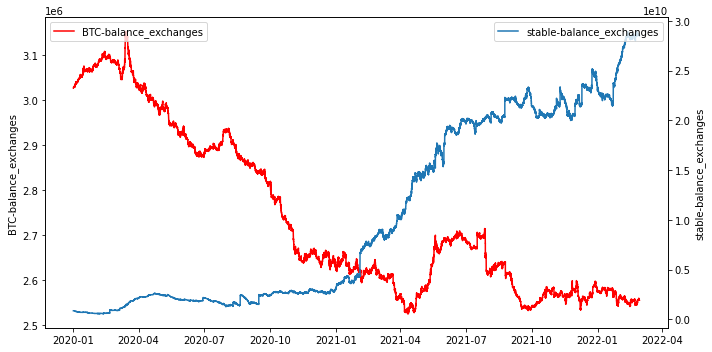

In [17]:
df1.plot2('BTC-balance_exchanges','stable-balance_exchanges')

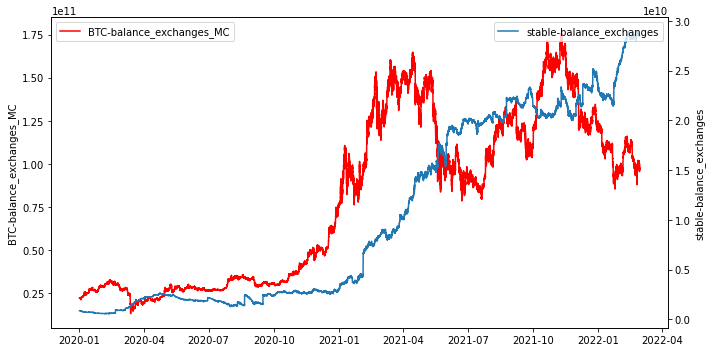

In [18]:
df1.plot2('BTC-balance_exchanges_MC','stable-balance_exchanges')

In [13]:
df1['BTCSSR'] = df1['BTC-balance_exchanges_MC']/df1['stable-balance_exchanges']
df2 = df1.drop('BTC-balance_exchanges_MC', axis=1).dropna()

<AxesSubplot:>

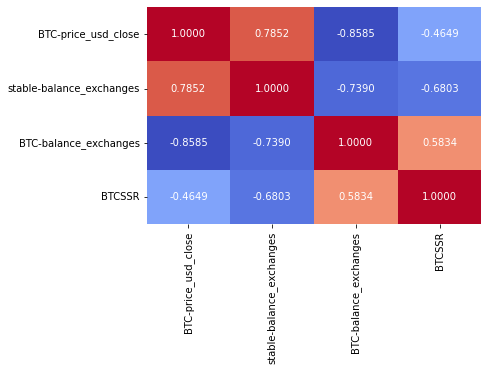

In [14]:
fig, ax = plt.subplots()
sns.heatmap(df2.corr(method='pearson'), annot=True, fmt='.4f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)

In [15]:
df3 = df2.copy()
df3['ret'] = df3['BTC-price_usd_close'].pct_change()
df3['r+5'] = df3['BTC-price_usd_close'].pct_change(periods=5).shift(-5)
df3['r+10'] = df3['BTC-price_usd_close'].pct_change(periods=10).shift(10)
df3['r+100'] = df3['BTC-price_usd_close'].pct_change(periods=100).shift(100)

df3['stable_bal_chg'] = df3['stable-balance_exchanges'].diff()
df3['stable_bal_chg_lag1'] = df3['stable_bal_chg'].shift(1)
df3['BTCSSR_lag1'] = df3['BTCSSR'].shift(1)
df3['BTCSSR_chg'] = df3['BTCSSR'].diff()
df3['BTCSSR_chg_lag1'] = df3['BTCSSR_chg'].shift(1)

In [16]:
df3.dropna().count()

BTC-price_usd_close         113411
stable-balance_exchanges    113411
BTC-balance_exchanges       113411
BTCSSR                      113411
ret                         113411
r+5                         113411
r+10                        113411
r+100                       113411
stable_bal_chg              113411
stable_bal_chg_lag1         113411
BTCSSR_lag1                 113411
BTCSSR_chg                  113411
BTCSSR_chg_lag1             113411
dtype: int64

In [17]:
df4 = df3.dropna()[['stable_bal_chg', 'stable_bal_chg_lag1', 'BTCSSR', 'BTCSSR_chg', 'BTCSSR_chg_lag1', 'ret', 'r+5', 'r+10', 'r+100']]

In [18]:
df4.count()

stable_bal_chg         113411
stable_bal_chg_lag1    113411
BTCSSR                 113411
BTCSSR_chg             113411
BTCSSR_chg_lag1        113411
ret                    113411
r+5                    113411
r+10                   113411
r+100                  113411
dtype: int64

In [ ]:
df4a = df4.where(~np.isinf(df4), 0)

<AxesSubplot:>

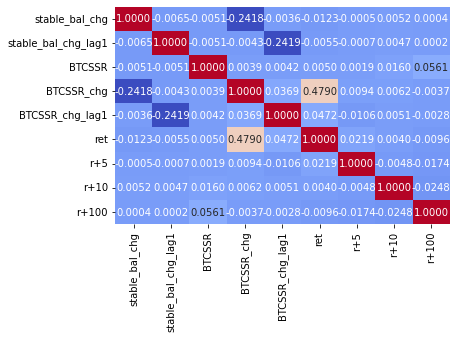

In [20]:
fig, ax = plt.subplots()
sns.heatmap(df4a.corr(method='pearson'), annot=True, fmt='.4f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)

In [21]:
calculate_corr_pvalues(df4a)

,stable_bal_chg,stable_bal_chg_lag1,BTCSSR,BTCSSR_chg,BTCSSR_chg_lag1,ret,r+5,r+10,r+100
stable_bal_chg,0.0,0.0281,0.088,0.0,0.2263,0.0,0.8618,0.0823,0.8832
stable_bal_chg_lag1,0.0281,0.0,0.0857,0.1467,0.0,0.063,0.807,0.1165,0.9469
BTCSSR,0.088,0.0857,0.0,0.1881,0.1561,0.0916,0.5192,0.0,0.0
BTCSSR_chg,0.0,0.1467,0.1881,0.0,0.0,0.0,0.0016,0.0367,0.2132
BTCSSR_chg_lag1,0.2263,0.0,0.1561,0.0,0.0,0.0,0.0003,0.0856,0.3496
ret,0.0,0.063,0.0916,0.0,0.0,0.0,0.0,0.1728,0.0013
r+5,0.8618,0.807,0.5192,0.0016,0.0003,0.0,0.0,0.1092,0.0
r+10,0.0823,0.1165,0.0,0.0367,0.0856,0.1728,0.1092,0.0,0.0
r+100,0.8832,0.9469,0.0,0.2132,0.3496,0.0013,0.0,0.0,0.0


### Backtest

In [22]:
price = pd.read_pickle(os.path.join(LOCAL_DATA_DIR,'BTC-PERP@ftx.pickle'))

In [23]:
df4a.groupby(pd.cut(df4a['BTCSSR_chg_lag1'], 10)).agg({'ret': lambda x: x.mean(skipna=True)})

,ret
BTCSSR_chg_lag1,
"(-14.694, -12.844]",0.000816
"(-12.844, -11.012]",NaN
"(-11.012, -9.18]",NaN
"(-9.18, -7.348]",NaN
"(-7.348, -5.516]",0.003343
"(-5.516, -3.684]",0.001313
"(-3.684, -1.852]",0.002067
"(-1.852, -0.02]",-0.000193
"(-0.02, 1.812]",0.000067


In [24]:
df4a.head(2)

,stable_bal_chg,stable_bal_chg_lag1,BTCSSR,BTCSSR_chg,BTCSSR_chg_lag1,ret,r+5,r+10,r+100
t,,,,,,,,,
2020-01-02 09:20:00,58984.566163,-678129.885007,25.645165,0.007058,0.012455,0.000345,0.001701,-0.002180,0.006508
2020-01-02 09:30:00,-167625.267626,58984.566163,25.639231,-0.005934,0.007058,-0.000430,0.003049,-0.005359,0.007669


In [25]:
lookback = 4000 # ~= 1 months
df4a['BTCSSR_chg_lag1_mv4k'] = df4a['BTCSSR_chg_lag1'].rolling(lookback).mean()

In [26]:
t0 = time.time()
pctrank = lambda x: pd.Series(x).rank(pct=True).iloc[-1]
df4a['BTCSSR_chg_lag1_pctrank4k'] = df4a['BTCSSR_chg_lag1'].rolling(lookback).apply(pctrank)
print(time.time()-t0)
Audio(sound_file, autoplay=True)

49.88531827926636


In [27]:
t0 = time.time()
pctrank = lambda x: pd.Series(x).rank(pct=True).iloc[-1]
df4a['BTCSSR_pctrank4k'] = df4a['BTCSSR'].rolling(lookback).apply(pctrank)
print(time.time()-t0)
Audio(sound_file, autoplay=True)

45.4398729801178


In [28]:
df4b = df4a[df4a.index>='20210101']

In [29]:
df4b[['ret','r+5','r+10','r+100']].describe()

,ret,r+5,r+10,r+100
count,60907.000000,60907.000000,60907.000000,60907.000000
mean,0.000011,0.000056,0.000110,0.001138
std,0.003632,0.008239,0.011575,0.035551
min,-0.091794,-0.137096,-0.142681,-0.231345
25%,-0.001503,-0.003462,-0.005003,-0.016807
50%,-0.000003,0.000082,0.000106,0.000809
75%,0.001512,0.003563,0.005313,0.019869
max,0.066014,0.134483,0.166661,0.202109


<AxesSubplot:xlabel='BTCSSR_chg_lag1_pctrank4k'>

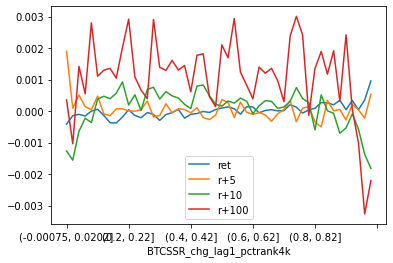

In [30]:
df4b_gp = df4b.groupby(pd.cut(df4b['BTCSSR_chg_lag1_pctrank4k'], 50)).agg({'ret': lambda x: x.mean(skipna=True),
                                                                 'r+5': lambda x: x.mean(skipna=True), 
                                                                 'r+10': lambda x: x.mean(skipna=True),
                                                                 'r+100': lambda x: x.mean(skipna=True)})
df4b_gp.plot()

In [31]:
df4b.groupby(pd.cut(df4b['BTCSSR_chg_lag1_pctrank4k'], 20)).agg({'ret': lambda x: x.mean(skipna=True),
                                                                 'r+5': lambda x: x.mean(skipna=True), 
                                                                 'r+10': lambda x: x.mean(skipna=True),
                                                                 'r+100': lambda x: x.mean(skipna=True)})

,ret,r+5,r+10,r+100
BTCSSR_chg_lag1_pctrank4k,,,,
"(-0.00075, 0.0502]",-0.000280,0.000914,-0.001276,0.000014
"(0.0502, 0.1]",-0.000047,0.000178,-0.000349,0.001647
"(0.1, 0.15]",-0.000133,0.000087,0.000402,0.001068
"(0.15, 0.2]",-0.000277,0.000057,0.000693,0.001673
"(0.2, 0.25]",-0.000083,0.000067,0.000216,0.001712
"(0.25, 0.3]",-0.000098,0.000009,0.000663,0.001457
"(0.3, 0.35]",-0.000118,0.000004,0.000517,0.001510
"(0.35, 0.4]",-0.000125,0.000067,0.000333,0.001309
"(0.4, 0.45]",-0.000113,0.000066,0.000547,0.000813


<AxesSubplot:xlabel='BTCSSR_pctrank4k'>

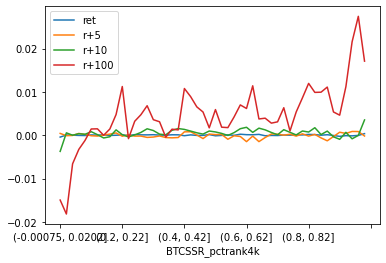

In [32]:
df4b_gp2 = df4b.groupby(pd.cut(df4b['BTCSSR_pctrank4k'],50)).agg({'ret': lambda x: x.mean(skipna=True),
                                                                 'r+5': lambda x: x.mean(skipna=True), 
                                                                 'r+10': lambda x: x.mean(skipna=True),
                                                                 'r+100': lambda x: x.mean(skipna=True)})
df4b_gp2.plot()

In [33]:
freq='1Min'
sl=4
tp=5
p=price.resample('1Min').last().ffill()
request = ['pf','backtest']

In [35]:
t0 = time.time()
signalid = 'long-BTCSSR_pctrank4k'
feature = 'BTCSSR_pctrank4k'
short=False

In [ ]:
res=[]
price = p.copy()
counter0 = 0
for qtl in [0.995, 0.99, 0.975, 0.96]:
    signal = df4b[feature]>qtl # rolling max, keep the singal for a period (1 hour), good for combining with other signals
    signal = signal.reindex(p.index).ffill()
    for tp in [3,5,7, 10, 15, 20]:
        for sl in [0.5, 1, 2, 5, 10, 15, 20]:
            counter0 = counter0 + 1
            print(f'{counter0} : tp:{tp} sl:{sl} id:{signalid}')
            for n1 in [1,10,100]: # ignore this first
                for n2 in [101, 200, 1000]: # 
                    ressig=runsignal(price,signal=signal,tp=tp,sl=sl,ts=sl,n1=n1,n2=n2,rsil=30,rsih=50,rsilag=14,maf=5,mas=15,short=short,size=np.inf,fees=0.0007,freq='1Min',init_cash=10000,request=['pf','backtest'])
                    for k in ressig:
                        resd={"signalid":signalid,"qtl":qtl,"short":short,"tp":tp,"sl":sl,'k':k,'sr':ressig[k].sharpe_ratio(),'n1':n1,'n2':n2,'tr':ressig[k].total_return(),'ntrades':ressig[k].trades.count()/46.5} # rescale to number of weeks
                        res.append(resd)
print(time.time()-t0)
Audio(sound_file, autoplay=True)

In [51]:
signal.to_frame().save('sample_signal')

saved df to C:\core\tmp\sample_signal.pickle


### convert into single loop

In [ ]:
qtl = 0.99
signal = df4b[feature]>qtl # rolling max, keep the singal for a period (1 hour), good for combining with other signals
signal = signal.reindex(p.index).ffill()

signal

In [37]:
backtest_configs = []
for tp in [3, 5]:  
    for sl in [1, 2]:
        for n1 in [1,10]:
            for n2 in [101, 200]:
                param_dict = {}
                param_dict['tp'] = tp
                param_dict['sl'] = sl
                param_dict['n1'] = n1
                param_dict['n2'] = n2
                backtest_configs.append(param_dict)

In [58]:
import json
json.dumps(backtest_configs[1])

'{"tp": 3, "sl": 1, "n1": 1, "n2": 200}'

In [56]:
hash(tuple(sorted(backtest_configs[1].items())))

2371740983098413810

In [62]:
def partial_runsignal(param_dict):
    tp = param_dict['tp']
    sl = param_dict['sl']
    n1 = param_dict['n1']
    n2 = param_dict['n2']
    ressig=runsignal(price,signal=signal,tp=tp,sl=sl,ts=sl,n1=n1,n2=n2,rsil=30,rsih=50,rsilag=14,
                 maf=5,mas=15,short=short,size=np.inf,fees=0.0007,freq='1Min',init_cash=10000,request=['pf','backtest'])
    for k in ressig:
        resd={"signalid":signalid,"qtl":qtl,"short":short,"tp":tp,"sl":sl,'k':k,
              'sr':ressig[k].sharpe_ratio(),'n1':n1,'n2':n2,'tr':ressig[k].total_return(),'ntrades':ressig[k].trades.count()/46.5} # rescale to number of weeks
    return resd

In [63]:
from cdcqr.backtest.alfafactory import runsignal


In [ ]:
ret = parallel_jobs(partial_runsignal, backtest_configs)



In [72]:
pd.DataFrame(backtest_configs[1].values()).save('rest')

saved df to C:\core\tmp\rest.pickle


In [ ]:
partial_runsignal

In [ ]:
t0 = time.time()
signalid = 'long-BTCSSR_pctrank4k'
feature = 'BTCSSR_pctrank4k'
short=False

res=[]
price = p.copy()
counter0 = 0
for qtl in [0.995, 0.99, 0.975, 0.96]:
    signal = df4b[feature]>qtl # rolling max, keep the singal for a period (1 hour), good for combining with other signals
    signal = signal.reindex(p.index).ffill()
    for tp in [3,5,7, 10, 15, 20]:
        for sl in [0.5, 1, 2, 5, 10, 15, 20]:
            counter0 = counter0 + 1
            print(f'{counter0} : tp:{tp} sl:{sl} id:{signalid}')
            for n1 in [1,10,100]: # ignore this first
                for n2 in [101, 200, 1000]: # 
                    ressig=runsignal(price,signal=signal,tp=tp,sl=sl,ts=sl,n1=n1,n2=n2,rsil=30,rsih=50,rsilag=14,maf=5,mas=15,short=short,size=np.inf,fees=0.0007,freq='1Min',init_cash=10000,request=['pf','backtest'])
                    for k in ressig:
                        resd={"signalid":signalid,"qtl":qtl,"short":short,"tp":tp,"sl":sl,'k':k,'sr':ressig[k].sharpe_ratio(),'n1':n1,'n2':n2,'tr':ressig[k].total_return(),'ntrades':ressig[k].trades.count()/46.5} # rescale to number of weeks
                        res.append(resd)
print(time.time()-t0)
Audio(sound_file, autoplay=True)

In [169]:
tp=10
sl=10
n1=1
n2=1000
qtl=0.96
signal = df4b[feature]>qtl # rolling max, keep the singal for a period (1 hour), good for combining with other signals
signal = signal.reindex(p.index).ffill()

ressig=runsignal(price,signal=signal,tp=tp,sl=sl,ts=sl,n1=n1,n2=n2,rsil=30,rsih=50,rsilag=14,maf=5,mas=15,short=short,size=np.inf,fees=0.0007,freq='1Min',init_cash=10000,request=['pf','backtest'])

In [170]:
ressig['n_n_pf'].plot(subplots=['drawdowns','trade_pnl','cum_returns'])

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#9467bd'},
              'na…

In [1]:
t0 = time.time()
signalid = 'short-BTCSSR_chg_lag1'
feature = 'BTCSSR_chg_lag1_pctrank4k'
short=False

res=[]
price = p.copy()
counter0 = 0
for qtl in [0.99, 0.975, 0.95, 0.925]:
    signal = df4b[feature]>qtl
    signal = signal.reindex(p.index).ffill()
    for tp in [3,5,7]:
        for sl in [0.5, 1, 2]:
            counter0 = counter0 + 1
            print(f'{counter0} : tp:{tp} sl:{sl} id:{signalid}')
            for n1 in [1,10,100]: #
                for n2 in [101, 200, 1000]:
                    ressig=runsignal(price,signal=signal,tp=tp,sl=sl,ts=sl,n1=n1,n2=n2,rsil=30,rsih=50,rsilag=14,maf=5,mas=15,short=short,size=np.inf,fees=0.0007,freq='1Min',init_cash=10000,request=['pf','backtest'])
                    for k in ressig:
                        resd={"signalid":signalid,"qtl":qtl,"short":short,"tp":tp,"sl":sl,'k':k,'sr':ressig[k].sharpe_ratio(),'n1':n1,'n2':n2,'tr':ressig[k].total_return(),'ntrades':ressig[k].trades.count()/46.5} # rescale to number of weeks
                        res.append(resd)
print(time.time()-t0)
Audio(sound_file, autoplay=True)

NameError: name 'time' is not defined

In [143]:
print(time.time()-t0)

1825.440774679184


In [162]:
res_df = pd.DataFrame(res)

In [163]:
res_df['short'].value_counts()

False    21168
Name: short, dtype: int64

In [173]:
res_df.save('long-BTCSSR_pctrank4k_res_df')

saved df to C:\core\tmp\long-BTCSSR_pctrank4k_res_df.pickle


In [166]:
res_df.pv()

In [174]:
res_df.pv()

res_df.to_pickle()

## obv 
    * extend range for tp and sl
    * larger set of n1 and n2 seems good?

In [61]:
dfr = pd.DataFrame(res)

In [56]:
# dfr.to_pickle(os.path.join(LOCAL_DATA_DIR, 'ssr_bt_res_1.pkl'))

In [55]:
dfr.shape

(2592, 11)

In [62]:
dfr.pv()

In [ ]:
dfr['ma_tpsl_pf'].plot(subplots=['drawdowns','trade_pnl','cum_returns'])

In [59]:
# select subset and check
tp = 3
sl = 1
ts = 1
nn = 100
signal = getsignal3(0.99,20, 0.0,0)['s']
price = price0
short=True
ressig=runsignal(price,signal=signal,tp=tp,sl=sl,ts=ts,n1=1,n2=60,rsil=30,rsih=50,rsilag=14,maf=5,mas=15,short=short,size=np.inf,fees=0.0007,freq='1Min',init_cash=10000,request=['pf'])
ressig['ma_tpsl_pf'].plot(subplots=['drawdowns','trade_pnl','cum_returns'])

,signalid,qtl,short,tp,sl,k,sr,n1,n2,tr,ntrades
0,long-SSR_chg_lag1,0.995,False,3,0.5,ma_ma_pf,-4.548833,1,101,-0.234303,2.000000
1,long-SSR_chg_lag1,0.995,False,3,0.5,ma_ts_pf,-3.643043,1,101,-0.189338,1.907692
2,long-SSR_chg_lag1,0.995,False,3,0.5,ma_tpts_pf,-3.643043,1,101,-0.189338,1.907692
3,long-SSR_chg_lag1,0.995,False,3,0.5,ma_tpsl_pf,-0.807481,1,101,-0.100788,1.830769
4,long-SSR_chg_lag1,0.995,False,3,0.5,rsi_rsi_pf,-3.043960,1,101,-0.339459,3.600000


In [175]:
t0 = time.time()
signalid = 'short-BTCSSR_pctrank4k'
feature = 'BTCSSR_pctrank4k'
short=True

res=[]
price = p.copy()
counter0 = 0
for qtl in [0.005, 0.01, 0.02, 0.03, 0.05]:
    signal = df4b[feature]<qtl # rolling max, keep the singal for a period (1 hour), good for combining with other signals
    signal = signal.reindex(p.index).ffill()
    for tp in [3,5,7, 10, 15, 20]:
        for sl in [0.5, 1, 2, 5, 10, 15, 20]:
            counter0 = counter0 + 1
            print(f'{counter0} : tp:{tp} sl:{sl} id:{signalid}')
            for n1 in [1,10,100]: # ignore this first
                for n2 in [101, 200, 1000]: # 
                    ressig=runsignal(price,signal=signal,tp=tp,sl=sl,ts=sl,n1=n1,n2=n2,rsil=30,rsih=50,rsilag=14,maf=5,mas=15,short=short,size=np.inf,fees=0.0007,freq='1Min',init_cash=10000,request=['pf','backtest'])
                    for k in ressig:
                        resd={"signalid":signalid,"qtl":qtl,"short":short,"tp":tp,"sl":sl,'k':k,'sr':ressig[k].sharpe_ratio(),'n1':n1,'n2':n2,'tr':ressig[k].total_return(),'ntrades':ressig[k].trades.count()/46.5} # rescale to number of weeks
                        res.append(resd)
print(time.time()-t0)
Audio(sound_file, autoplay=True)

1 : tp:3 sl:0.5 id:short-BTCSSR_pctrank4k
2 : tp:3 sl:1 id:short-BTCSSR_pctrank4k
3 : tp:3 sl:2 id:short-BTCSSR_pctrank4k
4 : tp:3 sl:5 id:short-BTCSSR_pctrank4k
5 : tp:3 sl:10 id:short-BTCSSR_pctrank4k
6 : tp:3 sl:15 id:short-BTCSSR_pctrank4k
7 : tp:3 sl:20 id:short-BTCSSR_pctrank4k
8 : tp:5 sl:0.5 id:short-BTCSSR_pctrank4k
9 : tp:5 sl:1 id:short-BTCSSR_pctrank4k
10 : tp:5 sl:2 id:short-BTCSSR_pctrank4k
11 : tp:5 sl:5 id:short-BTCSSR_pctrank4k
12 : tp:5 sl:10 id:short-BTCSSR_pctrank4k
13 : tp:5 sl:15 id:short-BTCSSR_pctrank4k
14 : tp:5 sl:20 id:short-BTCSSR_pctrank4k
15 : tp:7 sl:0.5 id:short-BTCSSR_pctrank4k
16 : tp:7 sl:1 id:short-BTCSSR_pctrank4k
17 : tp:7 sl:2 id:short-BTCSSR_pctrank4k
18 : tp:7 sl:5 id:short-BTCSSR_pctrank4k
19 : tp:7 sl:10 id:short-BTCSSR_pctrank4k
20 : tp:7 sl:15 id:short-BTCSSR_pctrank4k
21 : tp:7 sl:20 id:short-BTCSSR_pctrank4k
22 : tp:10 sl:0.5 id:short-BTCSSR_pctrank4k
23 : tp:10 sl:1 id:short-BTCSSR_pctrank4k
24 : tp:10 sl:2 id:short-BTCSSR_pctrank4k
25 : 

In [178]:
res_df_s = pd.DataFrame(res)

In [177]:
res_df_s.save('short-BTCSSR_pctrank4k_res_df')

saved df to C:\core\tmp\short-BTCSSR_pctrank4k_res_df.pickle


In [179]:
res_df_s.pv()

In [5]:
a = []
b = [1,2]

a.extend(b)
a.extend(b)

In [6]:
a

[1, 2, 1, 2]